In [1]:
import os
import numpy as np
from netCDF4 import Dataset
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from shapely.geometry import mapping
import xarray as xr


In [2]:

data_dir = '../results/modis/sst_test/'
# shapefile_path = 'trend/SB_Big_shapefiles/Untitled-polygon.shp'
shapefile_path = 'trend/GEE_Exports_new/Water_Bodies_2018222.shp'
shapefile_path = 'trend/GEE_Exports_new4/Water_Bodies_2018222.shp'

varname = 'sst'
cmin, cmax = 12, 30  # Set the min and max values for the color scale
# Initialize a dictionary to hold the data for each month.
monthly_data = {month: [] for month in range(1, 13)}
yearly_data = {month: [] for month in range(2002, 2024)}
season_data  = {"winter": [], "spring": [], "summar": [],"autumn": []}
all_data = {"all": []}
print(monthly_data)
# Assuming these are the coordinates you want to crop to
# lat_min_crop, lat_max_crop = 34.3, 35.7  # Update these values as needed
# lon_min_crop, lon_max_crop = 138.3, 140.23  # Update these values as needed

lat_min_crop, lat_max_crop = 34.5, 35.4
lon_min_crop, lon_max_crop = 138.8, 139.9
# lat_min_crop, lat_max_crop = 34.4, 35.7
# lon_min_crop, lon_max_crop = 138.35, 140.2
# rectangle_coords = [(35.7,  138.35), (35.7, 140.2), (34.4, 140.2), (34.4,  138.35), (35.7,  138.35)]


# Loop through files and accumulate data
# for fol in os.listdir(data_dir):
    # print(fol)
for file_name in os.listdir(data_dir):
    # print(file_name)
    if file_name.endswith('.nc'):
        year, month = int(file_name[1:5]), int(file_name[5:7])  # Modis
        # year, month = int(file_name[2:6]), int(file_name[6:8])   # GCOMC
        if year < 2003 or year > 2022:
            continue
        print(file_name)
        file_path = os.path.join(data_dir, file_name)
        shapefile = gpd.read_file(shapefile_path)
        
        # Step 1: Project the shapefile to a suitable projected CRS for your area
        # For Sagami Bay, Japan, you might use a UTM zone like EPSG:3099. Adjust as necessary.
        shapefile_proj = shapefile.to_crs(epsg=3099)  # Change to the appropriate EPSG code for your area

        # Step 2: Buffer the geometries in the projected CRS (500 meters)
        buffered_shapefile_proj = shapefile_proj.buffer(-2000)

        # Optional: Project back to the original CRS if needed
        buffered_shapefile = buffered_shapefile_proj.to_crs(epsg=4326)

        # Continue with your existing code for clipping...
        # Open the netCDF file using xarray and convert it to a raster using rioxarray
        ds = xr.open_dataset(file_path)
        ds = ds.rio.write_crs("epsg:4326")
        # Crop the dataset using the buffered geometry
        cropped_ds = ds.rio.clip(buffered_shapefile.geometry.apply(mapping), crs=4326, drop=True)

        # # Step 1: Project the shapefile to a suitable projected CRS for your area
        # # For Sagami Bay, Japan, you might use a UTM zone like EPSG:3099. Adjust as necessary.
        # shapefile_proj = shapefile.to_crs(epsg=3099)  # Change to the appropriate EPSG code for your area

        # # Step 2: Buffer the geometries in the projected CRS (500 meters)
        # buffered_shapefile_proj = shapefile_proj.buffer(-500)

        # # Optional: Project back to the original CRS if needed
        # buffered_shapefile = buffered_shapefile_proj.to_crs(epsg=4326)

        # cropped_ds = ds.rio.clip(buffered_shapefile.geometry.apply(mapping), crs=4326, drop=True)

        # Step 1: Project the shapefile to a suitable projected CRS for your area
        # For Sagami Bay, Japan, you might use a UTM zone like EPSG:3099. Adjust as necessary.
        # shapefile_proj = shapefile.to_crs(epsg=3099)  # Change to the appropriate EPSG code for your area

        # # Step 2: Buffer the geometries in the projected CRS (500 meters)
        # buffered_shapefile_proj = shapefile_proj.buffer(-100)

        # # Optional: Project back to the original CRS if needed
        # buffered_shapefile = buffered_shapefile_proj.to_crs(epsg=4326)

        # # Continue with your existing code for clipping...
        # # Open the netCDF file using xarray and convert it to a raster using rioxarray
        # cropped_ds = ds.rio.clip(buffered_shapefile.geometry.apply(mapping), crs=4326, drop=True)

        # crop  the data to the region of interest with shapefile
        # shapefile = shapefile.to_crs("EPSG:4326")
                
        # ds = xr.open_dataset(file_path)
        # ds = ds.rio.write_crs("epsg:4326")  # Assuming your netCDF data is in WGS 84; change this as necessary
        # Get the bounding box of the shapefile
        # cropped_ds = ds.rio.clip(shapefile.geometry.apply(mapping), shapefile.crs, drop=True)
        # lets take 500m buffer around the shapefile to exclude the data from the buffer
        # print("cropping the data to the shapefile...")
        # cropped_ds = ds.rio.clip(shapefile.geometry.apply(lambda x: x.buffer(-0.5)), shapefile.crs, drop=True)
        # cropped_ds = ds.rio.clip(shapefile.geometry.buffer(1).apply(mapping), shapefile.crs, drop=True)
        # cropped_ds = ds.rio.clip(shapefile.geometry.buffer(-0.5).apply(mapping), shapefile.crs, drop=True)
        # print("cropped")

        lat = cropped_ds['lat'].values
        lon = cropped_ds['lon'].values
        sst = cropped_ds[varname].values
        data = np.squeeze(sst)

        with Dataset(file_path, 'r') as nc:
            # da = nc[varname][:]
            # # mask
            # data = np.ma.squeeze(da)
            # lat = nc['lat'][:]
            # lon = nc['lon'][:]
            # Find indices for cropping
            lat_inds = np.where((lat >= lat_min_crop) & (lat <= lat_max_crop))[0]
            lon_inds = np.where((lon >= lon_min_crop) & (lon <= lon_max_crop))[0]
            # Now add a check to ensure the indices are within the bounds of the array
            if lat_inds.size > 0 and lon_inds.size > 0: # Adjust the slicing based on the actual dimensions of sds
                data_cropped = data[lat_inds, :][:, lon_inds]  # This is the updated line for a 2D array
                lat_cropped = lat[lat_inds]
                lon_cropped = lon[lon_inds]
            else:
                print("No data within specified crop bounds.")
            # sds_cropped = sds[:, lat_inds, :][:, :, lon_inds]  # Assuming sds has a shape of [time, lat, lon]
            lat_cropped = lat[lat_inds]
            lon_cropped = lon[lon_inds]   
            # Convert masked values to NaN
            # data_cropped = np.where(data_cropped.mask, np.nan, data_cropped)
            # mask = np.where(~sds_cropped.mask, np.nan, 0)
            yearly_data[year].append(data_cropped)
            monthly_data[month].append(data_cropped)
            all_data["all"].append(data_cropped)

            if month in [12,1,2]:
                season_data["winter"].append(data_cropped)
            elif month in [3,4,5]:
                season_data["spring"].append(data_cropped)
            elif month in [6,7,8]:
                season_data["summar"].append(data_cropped)
            else: # 9 10 11  Autumn
                season_data["autumn"].append(data_cropped)
print(len(yearly_data))



{1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: [], 12: []}
A200301_SST_NW_month.nc


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



A200302_SST_NW_month.nc


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



A200303_SST_NW_month.nc


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



A200304_SST_NW_month.nc


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



A200305_SST_NW_month.nc


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



A200306_SST_NW_month.nc


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



A200307_SST_NW_month.nc


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



A200308_SST_NW_month.nc


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



A200309_SST_NW_month.nc


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



A200310_SST_NW_month.nc


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



A200311_SST_NW_month.nc


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



A200312_SST_NW_month.nc


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



22


In [ ]:
# print(yearly_data.keys())

In [3]:


from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plot, colors

hex_colors_chl = [
    '#3500a8',  '#5C5CFF','#005EFF','#00FFFF',
     '#097969','#50C878',"#4CBB17",'#77f800','#DFFF00','yellow', "#FFBF00", "red",
    '#b30000', '#990000'
]


rgb_colors = [colors.hex2color(color) for color in hex_colors_chl]
# rgb_colors = ["blue", "#008080","green","#28B463", "yellow","orange","#FA8072","red","#811331"]
# rgb_colors = ["blue","#4169e1","lightgreen","green","#75E6DA", "yellow", "orange", "#f88379", "red"]

# rgb_colors = ["#4169e1","lightgreen","green","#75E6DA", "yellow", "orange", "#f88379", "red"]
# rgb_colors = [ "green",  "yellow","red"]
# rgb_colors = [
#     "green", "lightgreen", "limegreen", "yellowgreen", "yellow",
#     "gold", "orange", "coral", "darkorange","purple", "magenta", "fuchsia", "red",
#     "darkred", "maroon"te
# ]
print(monthly_data)
monthly_averages = {month: np.nanmean(np.stack(data_list), axis=0) for month, data_list in monthly_data.items() if data_list}
yearly_averages = {year: np.nanmean(np.stack(data_list), axis=0) for year, data_list in yearly_data.items() if data_list}
season_averages = {season: np.nanmean(np.stack(data_list), axis=0) for season, data_list in season_data.items() if data_list}
all_average = {str: np.nanmean(np.stack(data_list), axis=0) for str, data_list in all_data.items() if data_list}


{1: [array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [      nan, 17.68    , 17.58    , ...,       nan,       nan,
              nan],
       [      nan, 17.449999, 17.385   , ...,       nan,       nan,
              nan],
       [17.475   , 17.5     , 17.244999, ...,       nan,       nan,
              nan]], dtype=float32)], 2: [array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [      nan, 16.055   , 16.24    , ...,       nan,       nan,
              nan],
       [      nan, 15.91    , 16.164999, ...,       nan,       nan,
 

C:\Users\Robel\AppData\Local\Temp\ipykernel_5644\1854614208.py:23: RuntimeWarning: Mean of empty slice
  monthly_averages = {month: np.nanmean(np.stack(data_list), axis=0) for month, data_list in monthly_data.items() if data_list}
C:\Users\Robel\AppData\Local\Temp\ipykernel_5644\1854614208.py:24: RuntimeWarning: Mean of empty slice
  yearly_averages = {year: np.nanmean(np.stack(data_list), axis=0) for year, data_list in yearly_data.items() if data_list}
C:\Users\Robel\AppData\Local\Temp\ipykernel_5644\1854614208.py:25: RuntimeWarning: Mean of empty slice
  season_averages = {season: np.nanmean(np.stack(data_list), axis=0) for season, data_list in season_data.items() if data_list}
C:\Users\Robel\AppData\Local\Temp\ipykernel_5644\1854614208.py:26: RuntimeWarning: Mean of empty slice
  all_average = {str: np.nanmean(np.stack(data_list), axis=0) for str, data_list in all_data.items() if data_list}


12
1
runnign nan nan 1


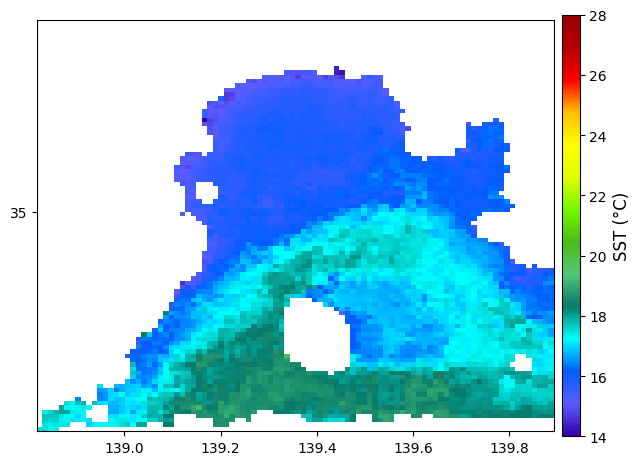

runnign nan nan 2


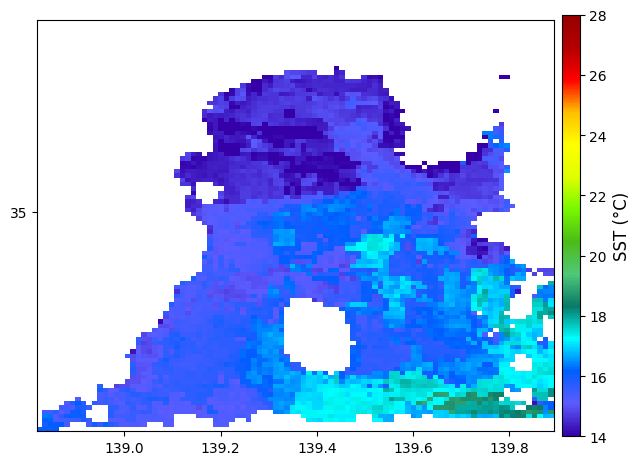

runnign nan nan 3


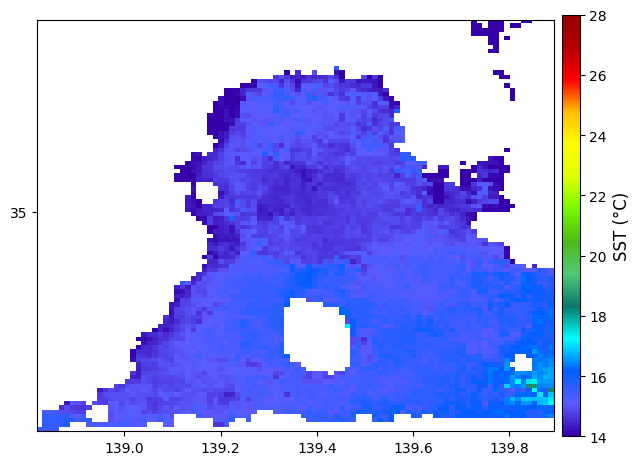

runnign nan nan 4


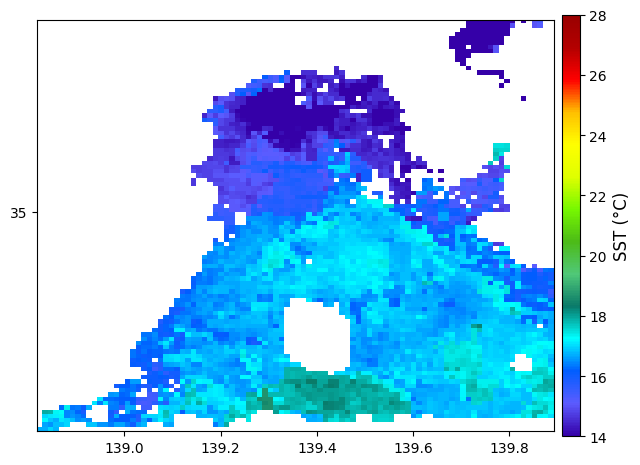

runnign nan nan 5


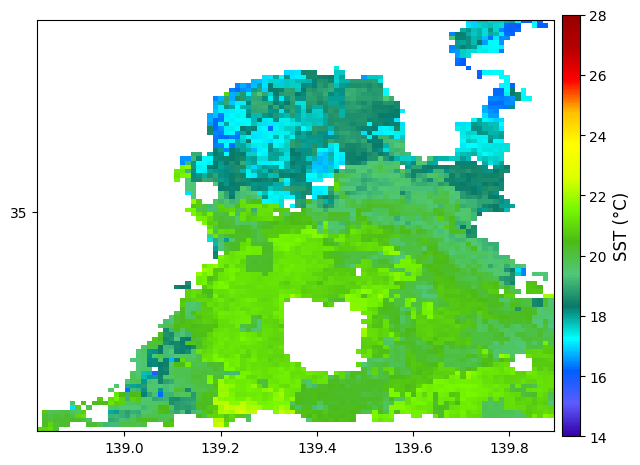

runnign nan nan 6


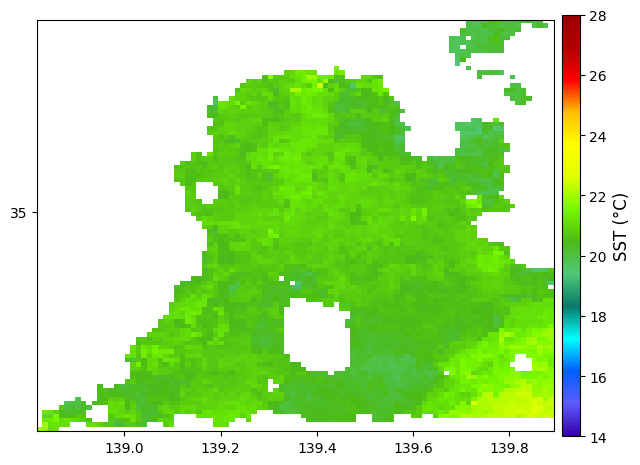

runnign nan nan 7


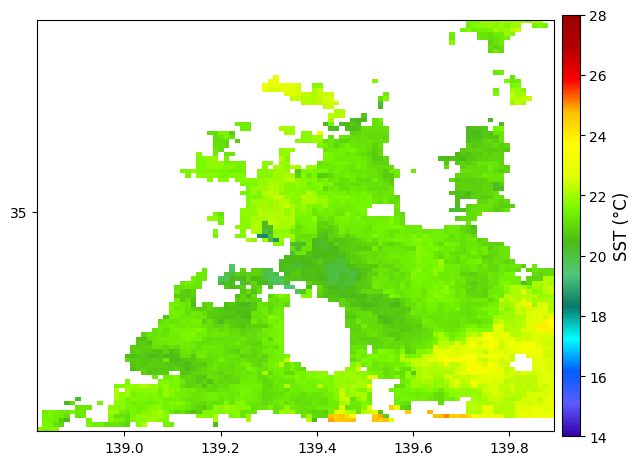

runnign nan nan 8


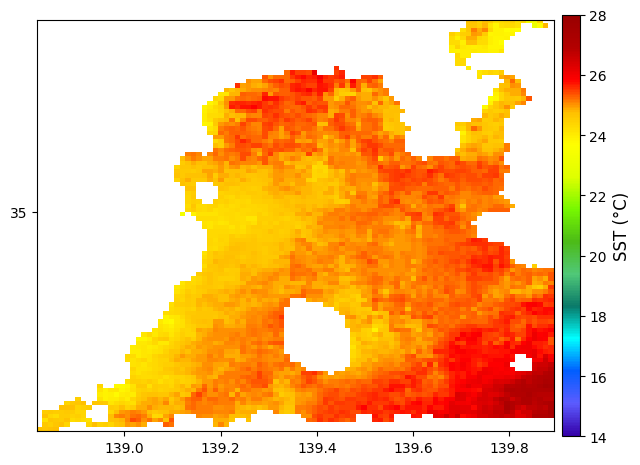

runnign nan nan 9


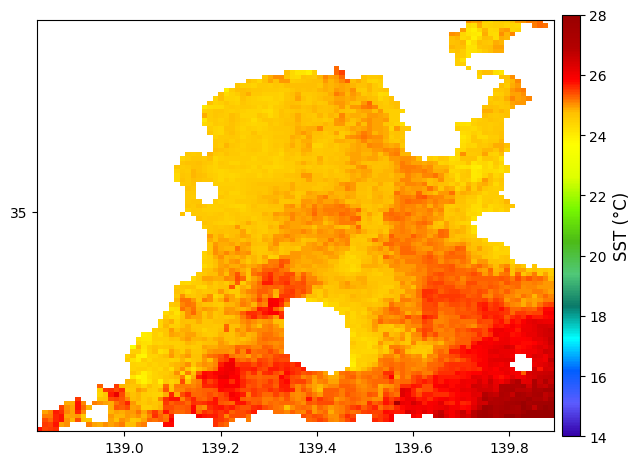

runnign nan nan 10


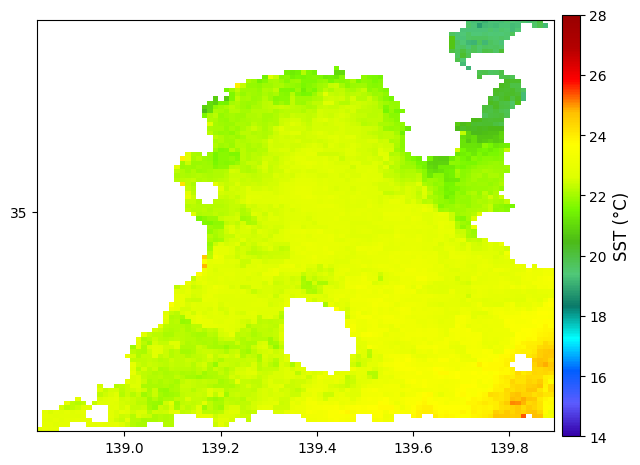

runnign nan nan 11


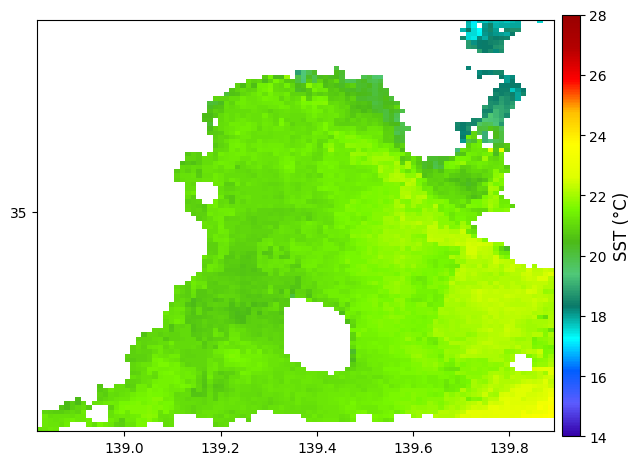

runnign nan nan 12


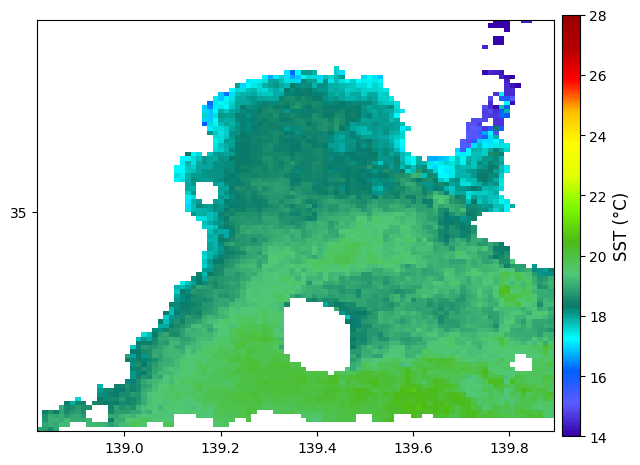

In [6]:

# cmin, cmax = -2,2
cmin, cmax = 14, 28
print(len(monthly_averages))
print(len(all_average))
for season, sds_cropped in monthly_averages.items():
    # if season == "winter":
    #     cmin, cmax = 15, 19
    # elif season == "spring":
    #     cmin, cmax = 15, 18
    # elif season == "summar":
    #     cmin, cmax = 23, 26
    # else: # autumn
    #     cmin, cmax = 20, 25

    print("runnign", sds_cropped.min(), sds_cropped.max(),season)
    if len(lon_cropped.shape) == 1:
        lon_cropped, lat_cropped = np.meshgrid(lon_cropped, lat_cropped)
    
    lon_0, lat_0 = (lon_cropped.min() + lon_cropped.max()), (lat_cropped.min() + lat_cropped.max()) / 2
    m = Basemap(llcrnrlon=lon_cropped.min(), llcrnrlat=lat_cropped.min(), 
                        urcrnrlon=lon_cropped.max(), urcrnrlat=lat_cropped.max(), resolution='i', 
                        lon_0=lon_0, lat_0=lat_0, projection='merc')

    # Adjust figsize to change the aspect ratio
    fig, ax = plot.subplots(figsize=(7, 6))  # Adjust the width and height to better suit your data aspect ratio
    
    # land and water contours
    # m.drawcoastlines()
    # m.drawcountries()
    # m.drawrivers()
    # m.drawmapboundary(fill_color='gray')
    # m.fillcontinents(color='lightgray', lake_color='gray')
    # m.drawparallels(np.arange(lat_cropped.min(), lat_cropped.max(), 0.2), labels=[1, 0, 0, 0])
    # m.drawmeridians(np.arange(lon_cropped.min(), lon_cropped.max(), 0.2), labels=[0, 0, 0, 1])

    # m.pcolormesh(lon_cropped, lat_cropped, sds_cropped, latlon=True, cmap=custom_colormap, vmin=cmin, vmax=cmax)
    # Create a mask for the data outside the contour range
    # data_mask = (sds_cropped < cmin) | (sds_cropped > cmax)

    # # Apply the mask to your data
    # sds_cropped_masked = np.ma.masked_where(data_mask, sds_cropped)

    # # Continue with your existing plotting code, but use the masked data
    # m.pcolormesh(lon_cropped, lat_cropped, sds_cropped_masked, latlon=True, cmap='jet', vmin=cmin, vmax=cmax)

    # figure bounds
    extent = [lon_cropped.min(), lon_cropped.max(), lat_cropped.min(), lat_cropped.max()]

    # Land mask
    # mask = np.where(~sds_cropped.mask, np.nan, 0)
    # mask 0 values with nan
    #  sds_cropped = np.where(sds_cropped ==0.0, np.nan, sds_cropped)
    ax.imshow(sds_cropped, cmap='gray', vmin=cmin, vmax=cmax, extent=extent)
    # ax.imshow(sds_cropped, cmap='gray', vmin=cmin, vmax=cmax, extent=extent)

    # Create a colormap object
    custom_colormap = LinearSegmentedColormap.from_list('custom', rgb_colors)

    # print(sds_cropped_log.max(), sds_cropped_log.min())

    # We no longer use LogNorm here since we've manually applied log10
    # ims = ax.imshow(sds_cropped_log, cmap='jet', extent=extent)
    # ims = ax.imshow(sds_cropped,vmin=cmin, vmax=cmax,   extent=extent)

    ims = ax.imshow(sds_cropped,vmin=cmin, vmax=cmax, cmap=custom_colormap, extent=extent)
     
    # # Figure labels
    # ax.set_xlabel('Longitude [$^\mathregular{o}$E]', fontsize="12")
    # ax.set_ylabel('Latitude [$^\mathregular{o}$N]', fontsize="12")
    ax.set_yticks(range(int(np.ceil(lat_cropped.min())), int(np.ceil(lat_cropped.max())), 1))
    # ax.set_title(time[0].strftime('%b %Y'))

    # # Colourbar
    # cbar = fig.colorbar(ims, ax=ax, orientation='vertical', fraction=0.0324, pad=0.025,  aspect=20)
    cbar = fig.colorbar(ims, ax=ax, orientation='vertical', fraction=0.0324, pad=0.015,  aspect=24)
    # cbar.set_label('log10(Chl-a) Conc. mg/m^3', fontsize="12")
    cbar.set_label('SST (°C)', fontsize="12")

    # ticks = [ims.get_clim()[0],((ims.get_clim()[0] + ims.get_clim()[1]) / 2), ims.get_clim()[1]] # This gets the color limit range
    # cbar.set_ticks(ticks)
    # cbar.set_ticklabels([f'{ticks[0]:.1f}', f'{ticks[1]:.1f}', f'{ticks[2]:.1f}']) # Format as desired

    # Small Sagami Bay
    lat_min, lat_max = 35.124, 35.34
    lon_min, lon_max = 139.115, 139.68

    # Use the 'data_cropped_masked' to ensure the near-land pixels are not plotted
    # plt.contourf(lon_cropped, lat_cropped, sds_cropped, levels=np.arange(23, 26, 1), cmap=custom_colormap)
    # plt.colorbar(label='SST (°C)')

    # plt.savefig(f'seasonal/final/Modis/average_sst_{season:02}_______test.png', dpi=300, bbox_inches='tight')
    # plt.savefig(f'seasonal/final/GCOM_SHAPE_average_sst_{month:02d}__test.png', dpi=300, bbox_inches='tight')
    plt.show()